In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6149535614381115953
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15683598464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 617635043339985118
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [3]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from skimage.filters import threshold_otsu
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Reshape
from keras.layers.experimental.preprocessing import RandomTranslation, RandomRotation, RandomWidth, RandomHeight, RandomZoom, Resizing

seed = 173
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
df = pd.read_csv("../input/digits-mini-dataset-5500/drawings_non_binary.csv")
mnist = pd.read_csv("../input/digit-recognizer/train.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [5]:
joint = pd.DataFrame(mnist.iloc[:, 1:].to_numpy())
joint["label"] = mnist.label
jointDf = pd.DataFrame(np.concatenate((joint, df), axis=0)).rename({784: "label"}, axis=1).sample(frac=1, random_state=seed)

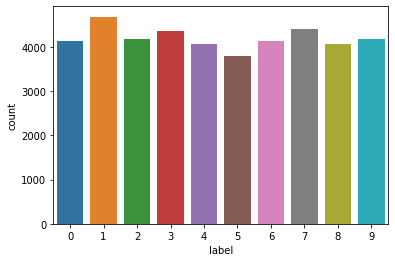

In [6]:
sns.countplot(x = joint.label);

In [7]:
y = to_categorical(jointDf.label)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(jointDf.iloc[:,:-1], y, train_size=0.9, random_state=seed) # no need to stratify for large balanced datasets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42759, 784), (4751, 784), (42759, 10), (4751, 10))

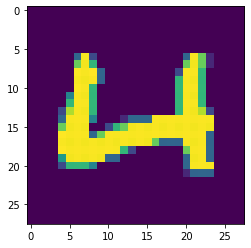

In [9]:
plt.imshow(np.array(x_test.sample(1, random_state=seed)).reshape(28, 28));

In [49]:
class GateOfLearning(Callback):
    """Increases learning rate when stuck at extrema, a friend to ReduceLROnPlateau, ModelCheckpoint callbacks.
    
    
    Example:
        ```python
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                    patience=5, min_lr=0.001)
        increase_lr = GateOfLearning(monitor='val_loss', factor=25,
                                      patience=8, max_lr=0.05)
        model.fit(X_train, Y_train, callbacks=[increase_lr, reduce_lr])
        ```
    
    
    Args:
        monitor: quantity to be monitored.
        factor: factor by which the learning rate will be reduced. Must be multitudes greater than that of the ReduceLROnPlateau
            `new_lr = lr * factor`.
        patience: number of epochs with no improvement after which learning rate will be increased. Must be greater than that of the ReduceLROnPlateau (6 by default)
        verbose: int. 0: quiet, 1: update messages. (1 by default)
        mode: one of `{'min', 'max'}`. In `'min'` mode, the learning rate will be increased when the quantity monitored has stopped decreasing; in `'max'` mode it will be increased when the quantity monitored has stopped increasing.
        cooldown: number of epochs to wait before resuming normal operation afterlr has been reduced. (0 by default)
        max_lr: upper bound on the learning rate. (initial value * 50 by default)
        sleep_till_reduce: do nothing untill seeing a reduction in the learning rate
    """
    
    
    def __init__(self, monitor = "val_loss", factor = 15.0, patience=6, verbose=1, mode = "min", cooldown = 0, max_lr = 999):
        # Sanity check
        if factor <= 1.0:
            raise ValueError("GateOfLearning does not support a factor <= 1.0.")
        
        if mode not in ["min", "max"]:
            raise ValueError(f"GateOfLearning does not support a mode '{mode}'. Use 'min' or 'max' instead.")
        
        # Init
        super(GateOfLearning, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.verbose = verbose
        self.objective = min if mode == "min" else max
        self.cooldown = cooldown
        self.max_lr = max_lr
        
        self.backup = (monitor, factor, patience, verbose, mode, cooldown, max_lr)
        
        self.observations = []
        self.lr_history = []
        self.last_opened = 0
    
    
    def _reset(self):
        """Reset state"""
        self.monitor, self.factor, self.patience, self.verbose, self.mode, self.cooldown, self.max_lr = self.backup
        
        self.observations = []
        self.lr_history = []
        self.last_opened = 0
        
    
    def on_train_begin(self, logs=None):
        """Training start handler"""
        self._reset()
    
    
    def open_gate(self):
        """Increases learning rate"""
        new_lr = self.lr_history[-1] * self.factor
        
        assert new_lr > self.lr_history[-1], f"old: {self.lr_history[-1]}, new: {new_lr}"
        
        if new_lr > self.max_lr:
            
            if self.verbose:
                print("Learning rate diverged. You can solve this problem by using a faster ReduceLROnPlateau, a smaller factor, or a bigger patience/cooldown.")
        else:
            old_lr = float(self.model.optimizer.learning_rate)
            self.model.optimizer.learning_rate = new_lr
            if self.verbose:
                print(f"\nGateOfLearning: Learning rate increased from {old_lr} to {float(self.model.optimizer.learning_rate)}")
    
    def on_epoch_end(self, epoch, logs=None):
        """Epoch end handler"""
        # Log learning rate.
        self.lr_history.append(logs["lr"])
        
        # Set the maximum learning rate to the initial or otherwise specified maximum learning rate
        if len(self.lr_history) <= 1:
            self.max_lr = min(self.max_lr, 50 * self.lr_history[0])
        
        # Check if the metric is reported, otherwise use default metrics.
        if self.monitor not in logs.keys():
            initMetric = self.monitor
            self.monitor = "val_loss" if "val_loss" in logs.keys() else "loss"
            if self.verbose:
                print(f"\nGateOfLearning: The '{initMetric}' metric was never reported. Using '{self.monitor}' instead.\n")
        
        # Log metric
        self.observations.append(logs[self.monitor])
        
        # Check if it is too early for an opening
        if len(self.observations) <= self.patience:
            return
        
        # Check if there is no improvement
        if self.objective(self.observations[-self.patience:]) == self.observations[-self.patience]:
            if epoch - self.last_opened > self.cooldown:
                self.open_gate()
                self.last_opened = epoch
                self.observations = [self.observations[-self.patience]]

In [50]:
def get_model(seed):
        model = Sequential([
                # Preprocessing
                Reshape((28, 28, 1), input_shape=(1, 28*28)),
                RandomRotation(0.1, seed=seed, fill_mode="constant", fill_value=0),
                RandomHeight(0.1, seed=seed, interpolation="bicubic"),
                RandomWidth(0.1, seed=seed, interpolation="bicubic"),
                RandomTranslation(0.12, 0.12, seed=seed, fill_mode="constant", fill_value=0),
                Resizing(28, 28, interpolation="bicubic"),


                # Subsampling-Convolution triplet 1
                Conv2D(32, kernel_size=5, padding="same", activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(48, kernel_size=5, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(64, kernel_size=5, padding="same", activation="relu", strides=2),
                BatchNormalization(axis=1),
                Dropout(0.3, seed=seed),


                # Subsampling-Convolution triplet 2
                Conv2D(64, kernel_size=5, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(82, kernel_size=5, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(112, kernel_size=7, padding="same", activation="relu", strides=2),
                BatchNormalization(axis=1),
                Dropout(0.3, seed=seed),

                # Decision-making
                Flatten(),
                Dense(512, activation="relu"),
                Dropout(0.4, seed=seed),
                Dense(28, activation="sigmoid"),
                BatchNormalization(axis=1),
                Dense(10, activation="softmax")])
        
        opt = RMSprop(learning_rate = 0.002, decay = 0)
        model.compile(opt, "categorical_crossentropy", metrics=["accuracy"])

        return model

lr_cut = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1, min_lr=0.000000001, mode="max", cooldown=3)
quicksave = ModelCheckpoint(monitor="val_accuracy", filepath="data/checkpoint.hdf5", verbose=1, save_best_only=True)
lr_boost = GateOfLearning(monitor="val_accuracy", factor=20, patience = 5, mode = "max", cooldown=3)

model = get_model(seed)
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
random_rotation_14 (RandomRo (None, 28, 28, 1)         0         
_________________________________________________________________
random_height_14 (RandomHeig (None, None, 28, 1)       0         
_________________________________________________________________
random_width_14 (RandomWidth (None, None, None, 1)     0         
_________________________________________________________________
random_translation_14 (Rando (None, None, None, 1)     0         
_________________________________________________________________
resizing_14 (Resizing)       (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 28, 28, 32)      

In [51]:
with tf.device("/device:GPU:0"):
    hist = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data = (x_test, y_test), shuffle=True, callbacks=[lr_cut, quicksave, lr_boost])

Epoch 1/40
1337/1337 [==============================] - 19s 12ms/step - loss: 0.8704 - accuracy: 0.7215 - val_loss: 0.1264 - val_accuracy: 0.9676

Epoch 00001: val_accuracy improved from -inf to 0.96759, saving model to data/checkpoint.hdf5
Epoch 2/40
1337/1337 [==============================] - 17s 13ms/step - loss: 0.1825 - accuracy: 0.9518 - val_loss: 0.0729 - val_accuracy: 0.9806

Epoch 00002: val_accuracy improved from 0.96759 to 0.98064, saving model to data/checkpoint.hdf5
Epoch 3/40
1337/1337 [==============================] - 16s 12ms/step - loss: 0.1233 - accuracy: 0.9671 - val_loss: 0.0554 - val_accuracy: 0.9863

Epoch 00003: val_accuracy improved from 0.98064 to 0.98632, saving model to data/checkpoint.hdf5
Epoch 4/40
1337/1337 [==============================] - 17s 12ms/step - loss: 0.0995 - accuracy: 0.9727 - val_loss: 0.0363 - val_accuracy: 0.9905

Epoch 00004: val_accuracy improved from 0.98632 to 0.99053, saving model to data/checkpoint.hdf5
Epoch 5/40
1337/1337 [=====

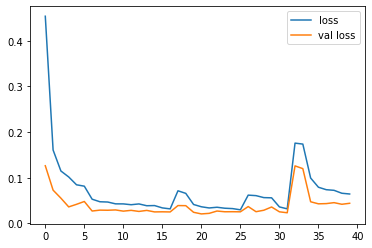

In [52]:
plt.plot(hist.history["loss"]);
plt.plot(hist.history["val_loss"]);
plt.legend(["loss", "val loss"]);

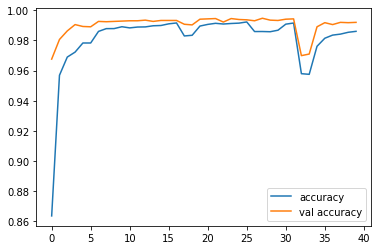

In [53]:
plt.plot(hist.history["accuracy"]);
plt.plot(hist.history["val_accuracy"]);
plt.legend(["accuracy", "val accuracy"]);